# Mobile Application Marketing (Part I)

## Context

In the mobile applications industry, marketing (better known as User Acquisition) is a key component to the success of a product. In this project, we will be looking at a dataset of the revenue stream generated by the mobile applications. We will be looking at the data from the perspective of a marketing analyst and will be looking to answer the following questions:

Can revenue be predicted based on prior application performance?
If so, what are the key features that drive the predictions?


## Understanding the business

### Business Objective

The marketing team wants to predict how much revenue will be generated by their new players. If the team can predict the revenue generated by their players, they will be able to optimize their advertising budget to maximize profit.

Ideally, the Marketing team would like to:

“Predict future revenue based on the first 7 days of revenue generated by our players”

Said in a different way (more technical):

“Given Spend, D0 Revenue, and D7 Revenue predict D14, D30, D60, D90, …, D360 Revenue”

### Data Problem Definition
We will be using this dataset to build a model that can predict the revenue generated by a player based on the features provided. We will also be looking at the features that drive the predictions of the model to provide insight to the marketing team.

### Data Analysis

- **date**: The date of the record.
- **sku**: SKU (Stock Keeping Unit) identifier.
- **network_name_hash**: A hashed representation of the network name.
- **region**: Geographical region.
- **days_after_install**: Days passed since the app was installed.
- **period**: Time period (in this case, it appears to be 'day' for all rows).
- **network_name**: Name of the network.
- **spend**: Amount spent.
- **cohort_size**: Size of the cohort.
- **organic_cohort_size**: Size of the organic cohort.
- **retained_users**: Number of users retained.
- **organic_retained_users**: Number of organic users retained.
- **revenue_ad**: Revenue from ads.
- **revenue_iap**: Revenue from in-app purchases.
- **revenue_sub**: Revenue from subscriptions.
- **organic_revenue_ad**: Organic revenue from ads.
- **organic_revenue_iap**: Organic revenue from in-app purchases.
- **organic_revenue_sub**: Organic revenue from subscriptions.

In [3]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



In [4]:
data = pd.read_csv('data/sample_data_1_ofuscated.csv')
data.head()


,date,sku,network_name_hash,region,days_after_install,period,network_name,spend,cohort_size,organic_cohort_size,retained_users,organic_retained_users,revenue_ad,revenue_iap,revenue_sub,organic_revenue_ad,organic_revenue_iap,organic_revenue_sub
0,2021-08-12,App T (iOS),81880948,T2,82,day,Channel U,237.275169,226.0,306.573488,1.0,3.534988,0.0251,0.0,0.0,0.112073,0.000000,0.0
1,2023-04-16,App T (android),81880948,T1,27,day,Channel U,0.000000,250.0,56.848112,6.0,1.536435,5.7208,0.0,0.0,0.251103,0.273815,0.0
2,2021-02-20,App W (iOS),81880948,T3,93,day,Channel U,0.000000,84.0,18.809504,4.0,0.750178,0.0100,0.0,0.0,0.007861,0.000000,0.0
3,2022-09-06,App T (iOS),81880948,T2,50,day,Channel U,52.953013,41.0,68.579913,1.0,1.068800,0.0501,0.0,0.0,0.074565,0.000000,0.0
4,2023-01-17,App T (android),81880948,T1,17,day,Channel U,905.814500,730.0,120.056114,41.0,4.621583,3.7005,0.0,0.0,1.304274,0.000000,0.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51405 entries, 0 to 51404
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    51405 non-null  object 
 1   sku                     51405 non-null  object 
 2   network_name_hash       51405 non-null  int64  
 3   region                  51405 non-null  object 
 4   days_after_install      51405 non-null  int64  
 5   period                  51405 non-null  object 
 6   network_name            51405 non-null  object 
 7   spend                   51405 non-null  float64
 8   cohort_size             51405 non-null  float64
 9   organic_cohort_size     51405 non-null  float64
 10  retained_users          51405 non-null  float64
 11  organic_retained_users  51405 non-null  float64
 12  revenue_ad              51405 non-null  float64
 13  revenue_iap             51405 non-null  float64
 14  revenue_sub             51405 non-null

In [6]:
data['network_name'].unique()

array(['Channel U', 'Channel A', 'Channel F'], dtype=object)

In [7]:
data.describe(include='all')

,date,sku,network_name_hash,region,days_after_install,period,network_name,spend,cohort_size,organic_cohort_size,retained_users,organic_retained_users,revenue_ad,revenue_iap,revenue_sub,organic_revenue_ad,organic_revenue_iap,organic_revenue_sub
count,51405,51405,5.140500e+04,51405,51405.000000,51405,51405,51405.000000,51405.000000,51405.000000,51405.000000,51405.000000,51405.000000,51405.000000,51405.000000,51405.000000,51405.000000,51405.000000
unique,947,4,NaN,5,NaN,2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2022-09-24,App T (iOS),NaN,T1,NaN,day,Channel F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,87,13040,NaN,10422,NaN,47374,17294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,6.288966e+08,NaN,67.485225,NaN,NaN,656.475111,757.279584,279.280557,30.496333,13.994421,8.523013,2.533183,0.356349,3.583773,1.525728,0.121277
std,NaN,NaN,4.758837e+08,NaN,55.016218,NaN,NaN,2137.080091,2368.111730,628.945684,285.023445,89.025590,121.754191,30.073635,4.363706,47.777589,15.211318,1.764583
min,NaN,NaN,8.188095e+07,NaN,0.000000,NaN,NaN,0.000000,-2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,8.188095e+07,NaN,30.000000,NaN,NaN,0.000000,0.000000,5.875000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000964,0.000000,0.000000
50%,NaN,NaN,5.617743e+08,NaN,60.000000,NaN,NaN,0.000000,47.000000,53.835555,1.000000,1.338605,0.000000,0.000000,0.000000,0.046275,0.000000,0.000000
75%,NaN,NaN,1.244348e+09,NaN,93.000000,NaN,NaN,212.598417,508.000000,267.887305,11.000000,8.561416,0.994600,0.000000,0.000000,0.660534,0.000000,0.000000


From the above statistics, we can see that:

- Many columns have a mean that's much higher than the median. This suggests that the data is skewed, with a few large values pulling the mean up.
- Many metrics have a median of $0, indicating that for at least half of the records, there was no spend, revenue, or user retention.


To get a clearer visual understanding, let's plot histograms for each of these columns.

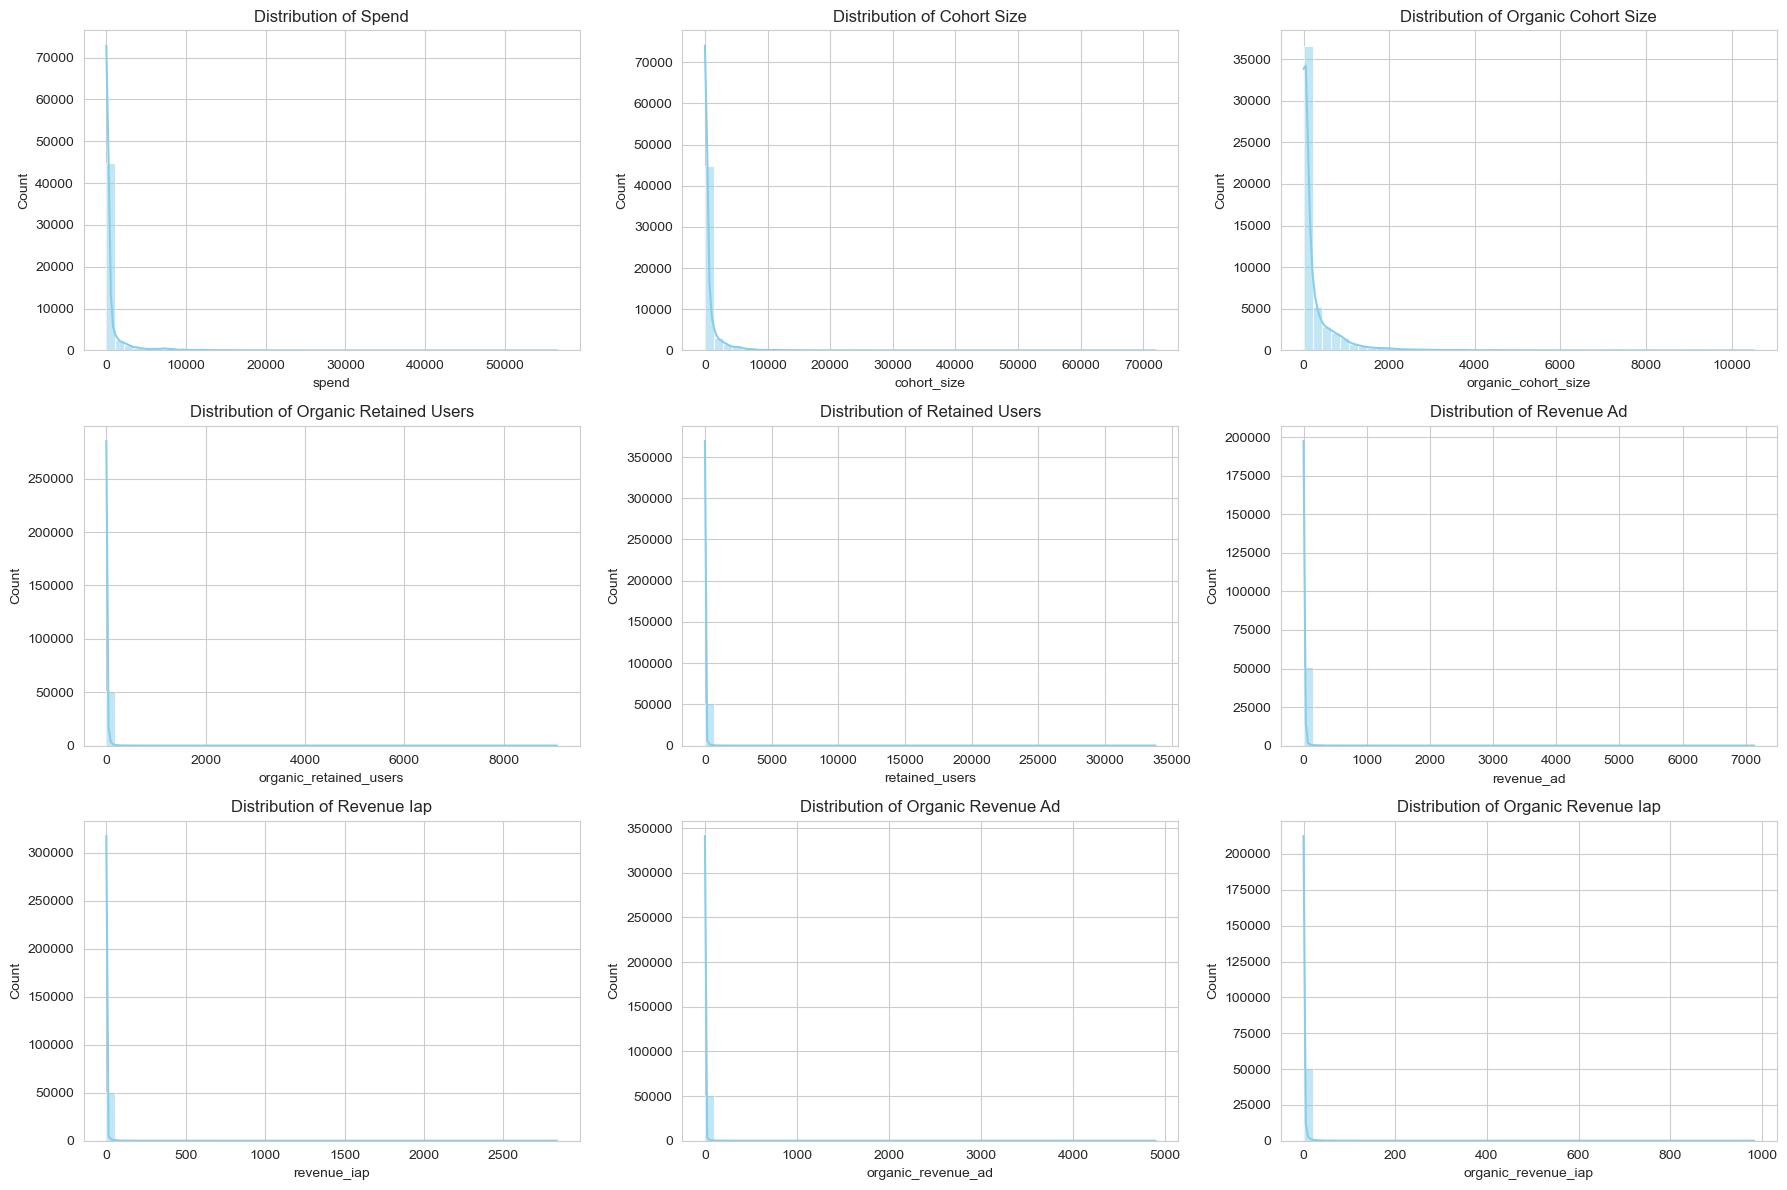

In [8]:

import matplotlib.pyplot as plt
import seaborn as sns

# Setting the style for the plots
sns.set_style('whitegrid')

# Columns to analyze
columns = ['spend', 'cohort_size', 'organic_cohort_size', 'organic_retained_users', 'retained_users', 'revenue_ad', 'revenue_iap', 'organic_revenue_ad', 'organic_revenue_iap']

# Titles for the plots
titles = []

for col in columns:
        titles.append('Distribution of ' + col.replace('_', ' ').title())


# Plotting histograms with log scale transformation
fig, axes = plt.subplots(3, 3, figsize=(18, 12))

for ax, col, title in zip(axes.ravel(), columns, titles):
    sns.histplot(data[col], bins=50, ax=ax, kde=True, color='skyblue', log_scale=False)
    ax.set_title(title)
    ax.set_ylabel('Count')
    
plt.tight_layout()
plt.show()
    

- **Spend**: The majority of records have a spend close to $0, and there's a long tail with a few records having significantly higher spends.
- **Cohort Size**: Most records have a smaller cohort size, but there are outliers with larger sizes.
- **Organic Cohort** Size: A similar pattern to the cohort size, with the majority of records having smaller organic cohort sizes.
- **Retained Users**: The majority of records have a low number of retained users, with a few having a significantly higher count.
- **Revenue from Ads**: Most records have revenue close to $0, with a long tail representing a few records with higher revenues.
- **Revenue from In-app Purchases**: A similar pattern to the revenue from ads.
- **Revenue from Subscriptions**: Most records have no subscription revenue, with a few exceptions.

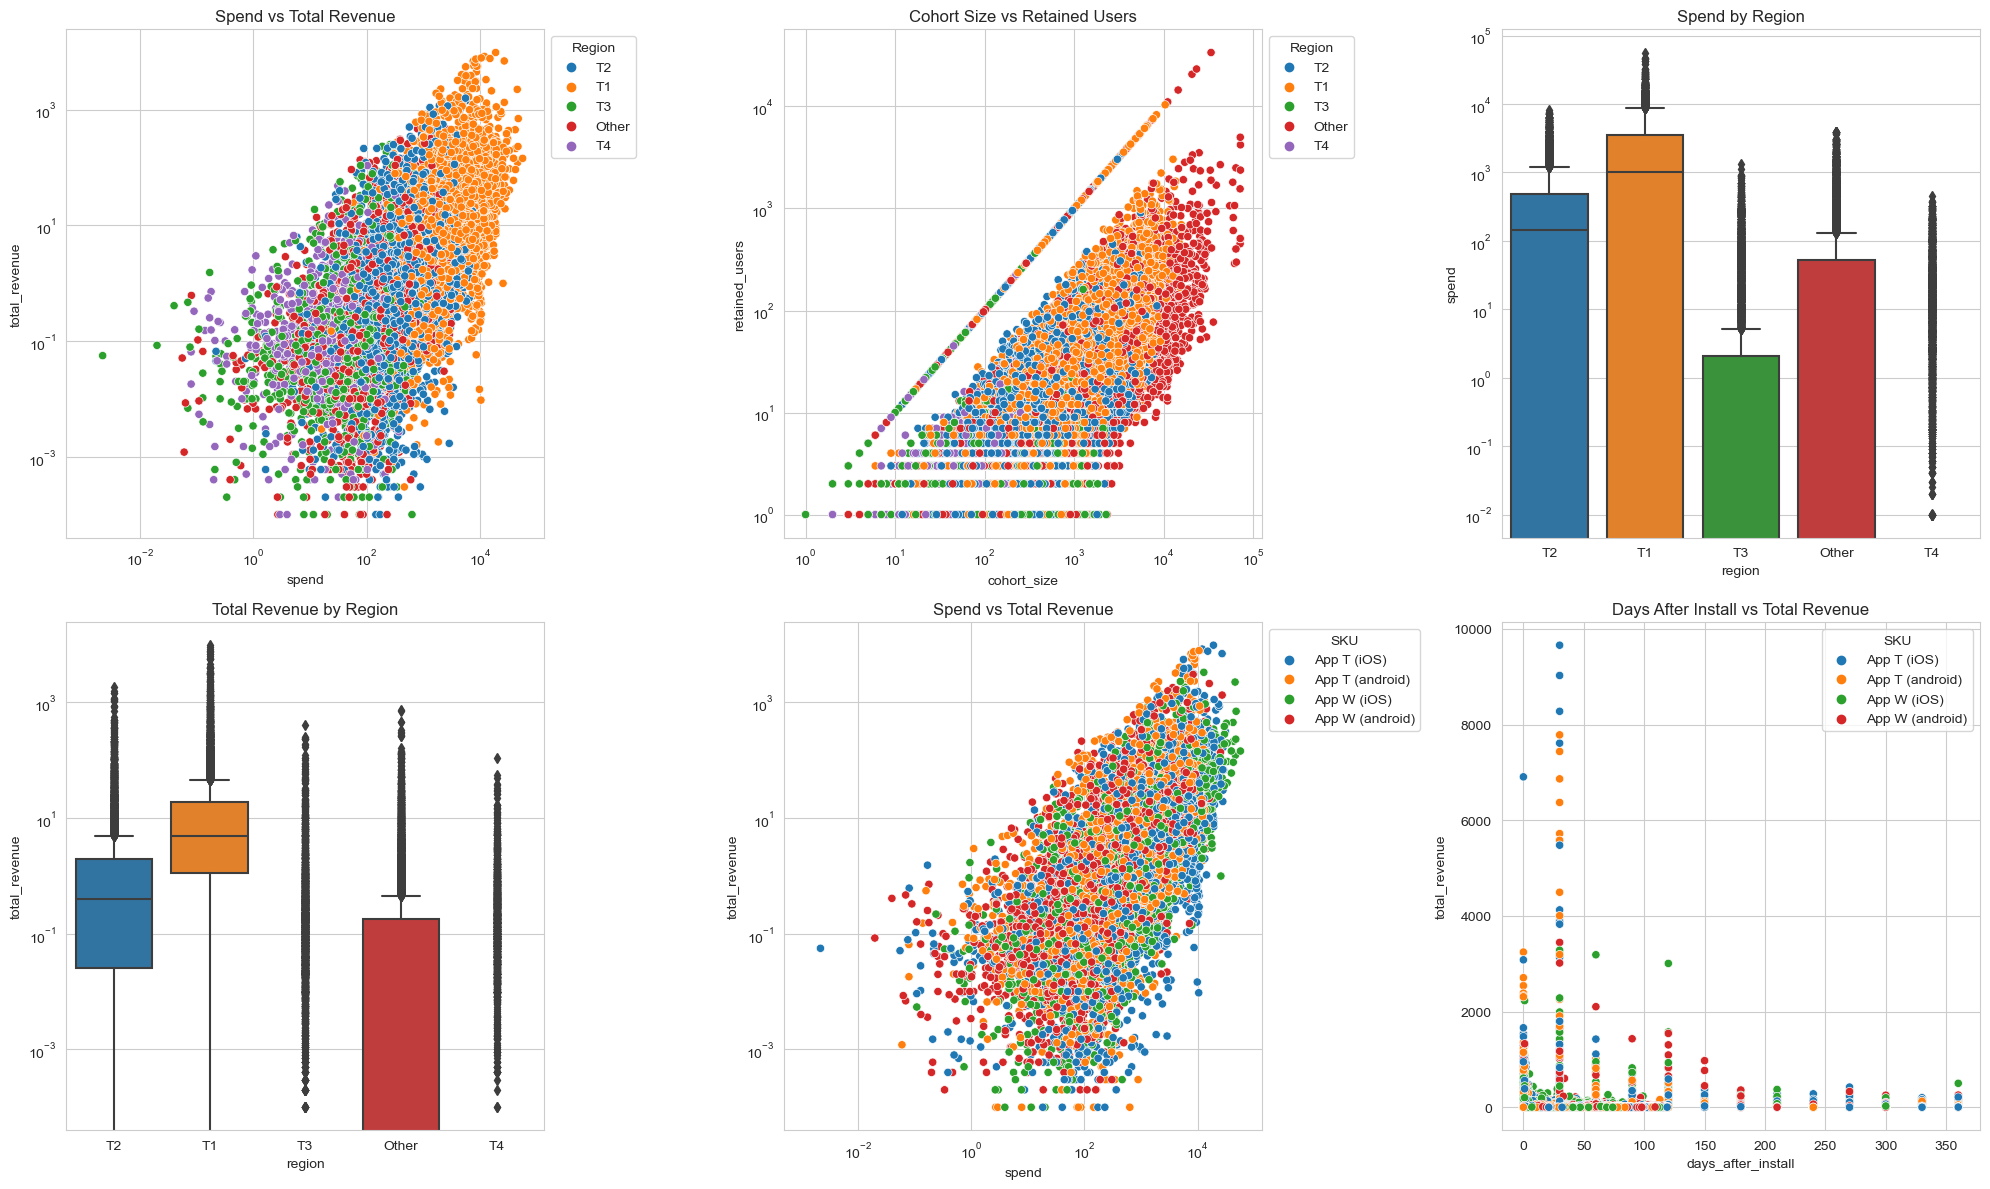

In [9]:

# Creating a 'total_revenue' column
data['total_revenue'] = data['revenue_ad'] + data['revenue_iap'] + data['revenue_sub']

# Multivariate plots
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Scatter plot for spend vs total revenue
sns.scatterplot(data=data, x='spend', y='total_revenue', hue='region', ax=axes[0, 0])
axes[0, 0].set_title('Spend vs Total Revenue')
axes[0, 0].set_xscale('log')
axes[0, 0].set_yscale('log')
axes[0, 0].legend(title='Region', bbox_to_anchor=(1, 1))

# 2. Scatter plot for cohort size vs retained users
sns.scatterplot(data=data, x='cohort_size', y='retained_users', hue='region', ax=axes[0, 1])
axes[0, 1].set_title('Cohort Size vs Retained Users')
axes[0, 1].set_xscale('log')
axes[0, 1].set_yscale('log')
axes[0, 1].legend(title='Region', bbox_to_anchor=(1, 1))

# 3. Box plot for spend by region
sns.boxplot(data=data, x='region', y='spend', ax=axes[0, 2])
axes[0, 2].set_title('Spend by Region')
axes[0, 2].set_yscale('log')

# 4. Box plot for total revenue by region
sns.boxplot(data=data, x='region', y='total_revenue', ax=axes[1, 0])
axes[1, 0].set_title('Total Revenue by Region')
axes[1, 0].set_yscale('log')

# 5. Scatter plot for spend vs total revenue
sns.scatterplot(data=data, x='spend', y='total_revenue', hue='sku', ax=axes[1, 1])
axes[1, 1].set_title('Spend vs Total Revenue')
axes[1, 1].set_xscale('log')
axes[1, 1].set_yscale('log')
axes[1, 1].legend(title='SKU', bbox_to_anchor=(1, 1))

# 6. Scatter plot for spend vs total revenue
sns.scatterplot(data=data, x='days_after_install', y='total_revenue', hue='sku', ax=axes[1, 2])
axes[1, 2].set_title('Days After Install vs Total Revenue')
# axes[1, 2].set_xscale('log')
# axes[1, 2].set_yscale('log')
axes[1, 2].legend(title='SKU', bbox_to_anchor=(1, 1))


plt.tight_layout()
plt.show()
    

- **Spend vs Total Revenue (by Region)**: There tends to be more spend (and revenue) on T1,T2 regions vs other regions.
- **Cohort Size vs Retained Users**: There are some interesting patterns here than need further investigation.
- **Spend by region** Other is top3 in spend, T4 doesn't get much spend - that's interesting.
- **Total Revenue by Region**: T1 and T2 at the top of the list - makes sense.
- **Spend vs Total Revenue (by SKU)**: No clear pattern here, needs more investigation.
- **Days After Install vs Total Revenue**: revenue drops over time.

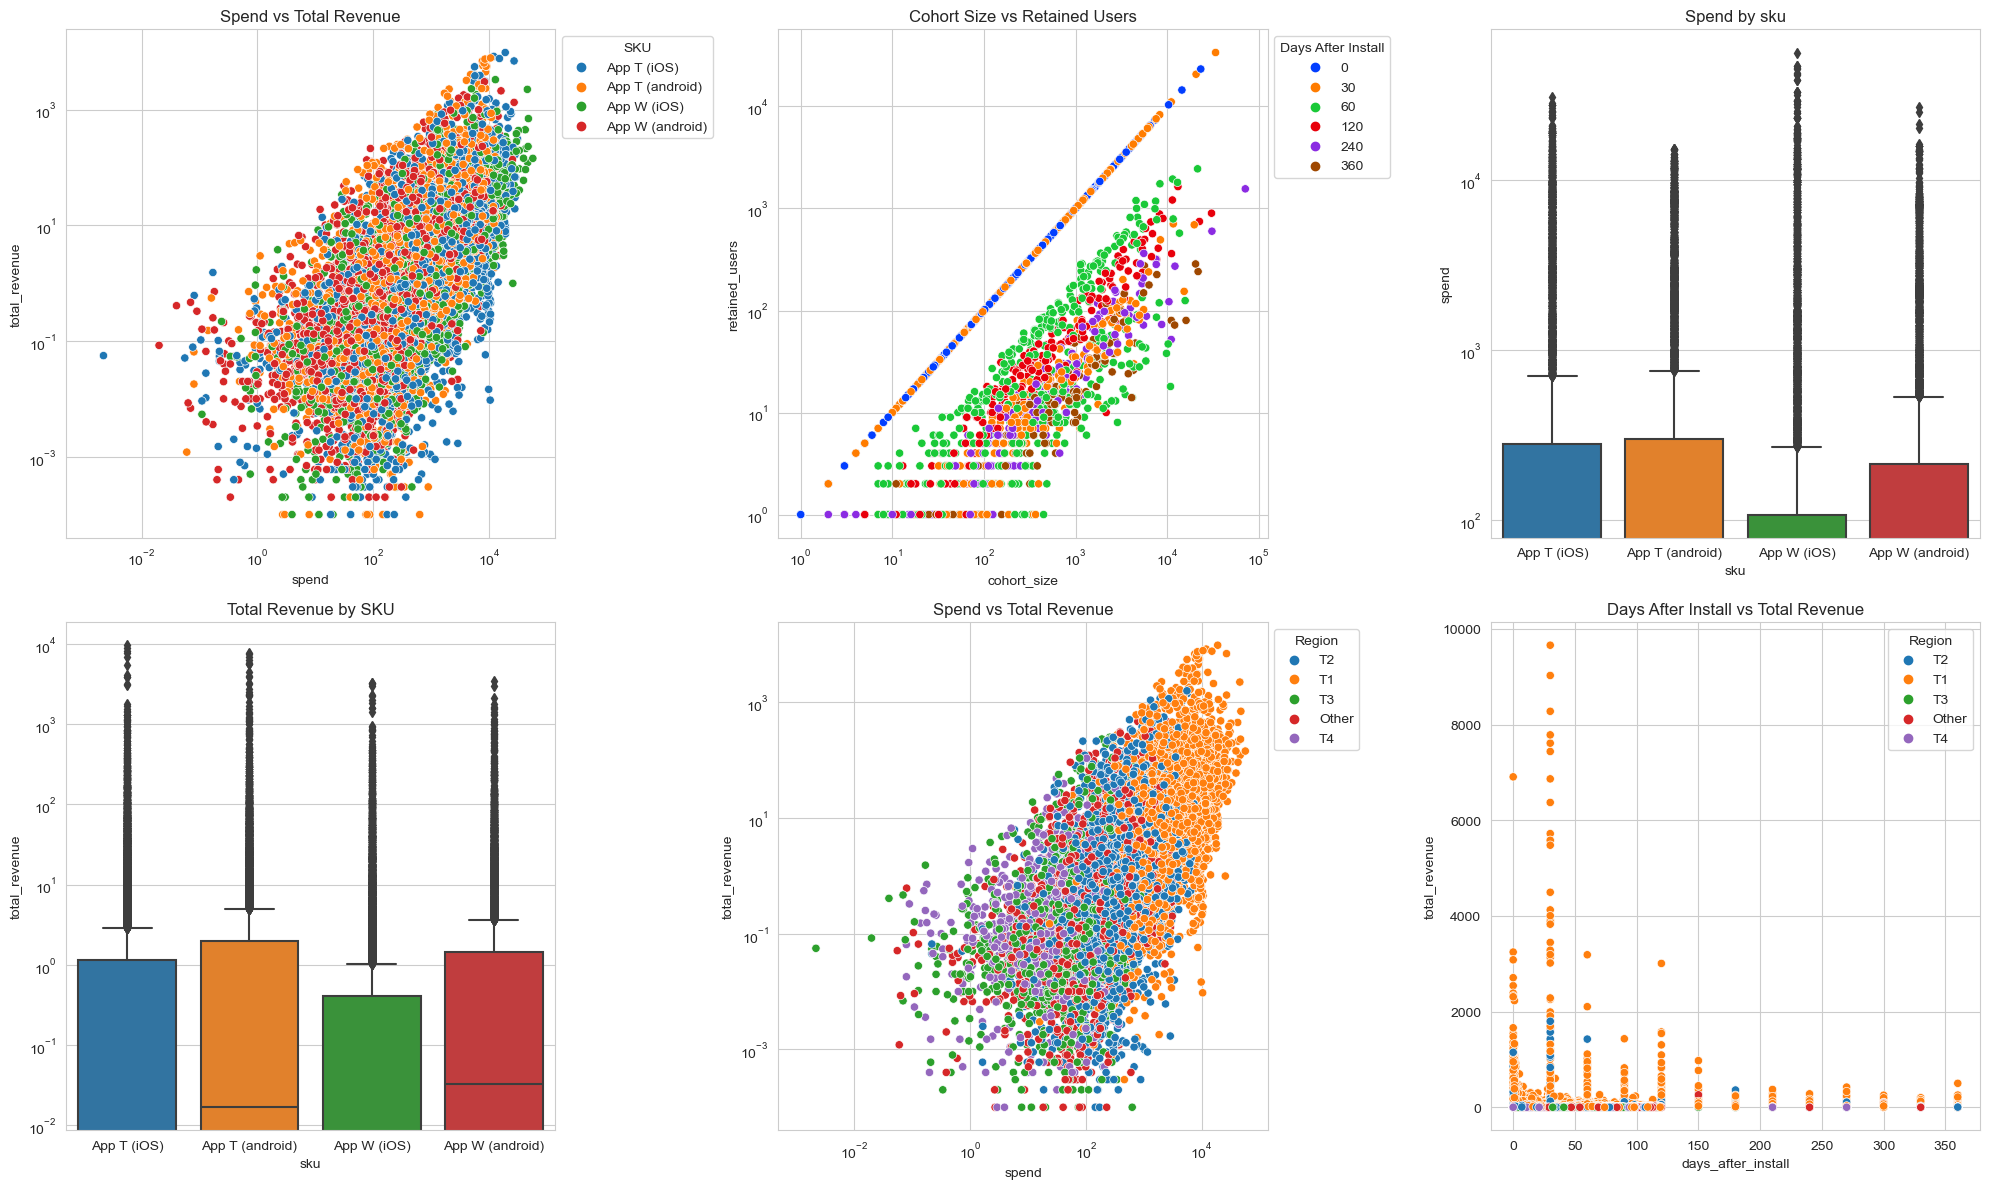

In [10]:

# Creating a 'total_revenue' column
data['total_revenue'] = data['revenue_ad'] + data['revenue_iap'] + data['revenue_sub']

# Multivariate plots
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Scatter plot for spend vs total revenue
sns.scatterplot(data=data, x='spend', y='total_revenue', hue='sku', ax=axes[0, 0])
axes[0, 0].set_title('Spend vs Total Revenue')
axes[0, 0].set_xscale('log')
axes[0, 0].set_yscale('log')
axes[0, 0].legend(title='SKU', bbox_to_anchor=(1, 1))

# 2. Scatter plot for cohort size vs retained users
palette_choice = sns.color_palette("bright")[0:6]
sns.scatterplot(data=data[data['days_after_install'].isin([0, 30, 60, 120, 240, 360])], x='cohort_size', y='retained_users', hue='days_after_install', ax=axes[0, 1], palette=palette_choice)
axes[0, 1].set_title('Cohort Size vs Retained Users')
axes[0, 1].set_xscale('log')
axes[0, 1].set_yscale('log')
axes[0, 1].legend(title='Days After Install', bbox_to_anchor=(1, 1))

# 3. Box plot for spend by region
sns.boxplot(data=data, x='sku', y='spend', ax=axes[0, 2])
axes[0, 2].set_title('Spend by sku')
axes[0, 2].set_yscale('log')

# 4. Box plot for total revenue by region
sns.boxplot(data=data, x='sku', y='total_revenue', ax=axes[1, 0])
axes[1, 0].set_title('Total Revenue by SKU')
axes[1, 0].set_yscale('log')

# 5. Scatter plot for spend vs total revenue
sns.scatterplot(data=data, x='spend', y='total_revenue', hue='region', ax=axes[1, 1])
axes[1, 1].set_title('Spend vs Total Revenue')
axes[1, 1].set_xscale('log')
axes[1, 1].set_yscale('log')
axes[1, 1].legend(title='Region', bbox_to_anchor=(1, 1))

# 6. Scatter plot for spend vs total revenue
sns.scatterplot(data=data, x='days_after_install', y='total_revenue', hue='region', ax=axes[1, 2])
axes[1, 2].set_title('Days After Install vs Total Revenue')
# axes[1, 2].set_xscale('log')
# axes[1, 2].set_yscale('log')
axes[1, 2].legend(title='Region', bbox_to_anchor=(1, 1))


plt.tight_layout()
plt.show()
    

- **Spend vs Total Revenue (by SKU)**: I was expecting to find a pattern here but it's not the case.
- **Cohort Size vs Retained Users (by days after install)**: The days_after_install dimension needs some work to actually be useful.
- **Spend by SKU** Aside from "App W (iOS)" the rest of the apps get very similar spend budgets.
- **Total Revenue by SKU**: "App W (iOS)" gives pretty good returns since the gap in revenue closed significantly (vs spend).
- **Spend vs Total Revenue (by region)**: We can see the same region trends as before.
- **Days After Install vs Total Revenue**: The T1 region clearly outperforms the other ones.

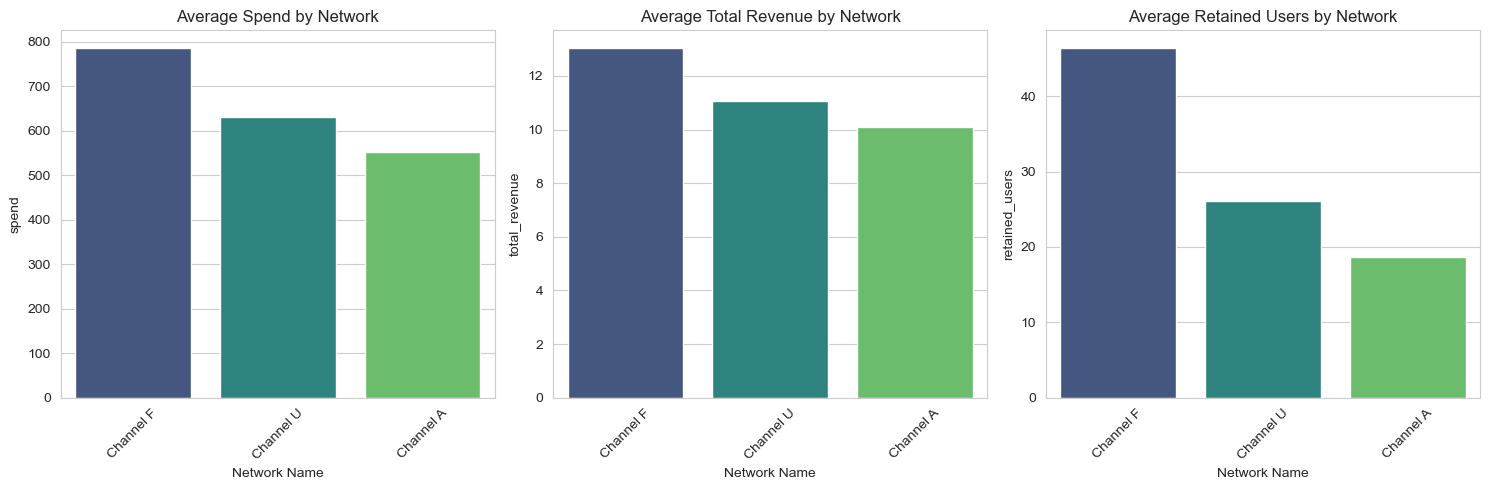

In [11]:

# Grouping data by 'network_name' and calculating the mean for selected metrics
network_grouped = data.groupby('network_name').agg({
    'spend': 'mean',
    'total_revenue': 'mean',
    'retained_users': 'mean'
}).reset_index()

# Sorting the dataframe by total revenue for better visualization
network_grouped = network_grouped.sort_values(by='total_revenue', ascending=False)

# Plotting the metrics by network
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Metrics and titles
metrics = ['spend', 'total_revenue', 'retained_users']
plot_titles = ['Average Spend by Network', 'Average Total Revenue by Network', 'Average Retained Users by Network']

for ax, metric, title in zip(axes, metrics, plot_titles):
    sns.barplot(x='network_name', y=metric, data=network_grouped, ax=ax, palette='viridis')
    ax.set_title(title)
    ax.set_ylabel(metric)
    ax.set_xlabel('Network Name')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
    

"Channel F" outperforms the other ones especially when it comes to retained users. That's probably the reason why it gets a bigger spend budget.

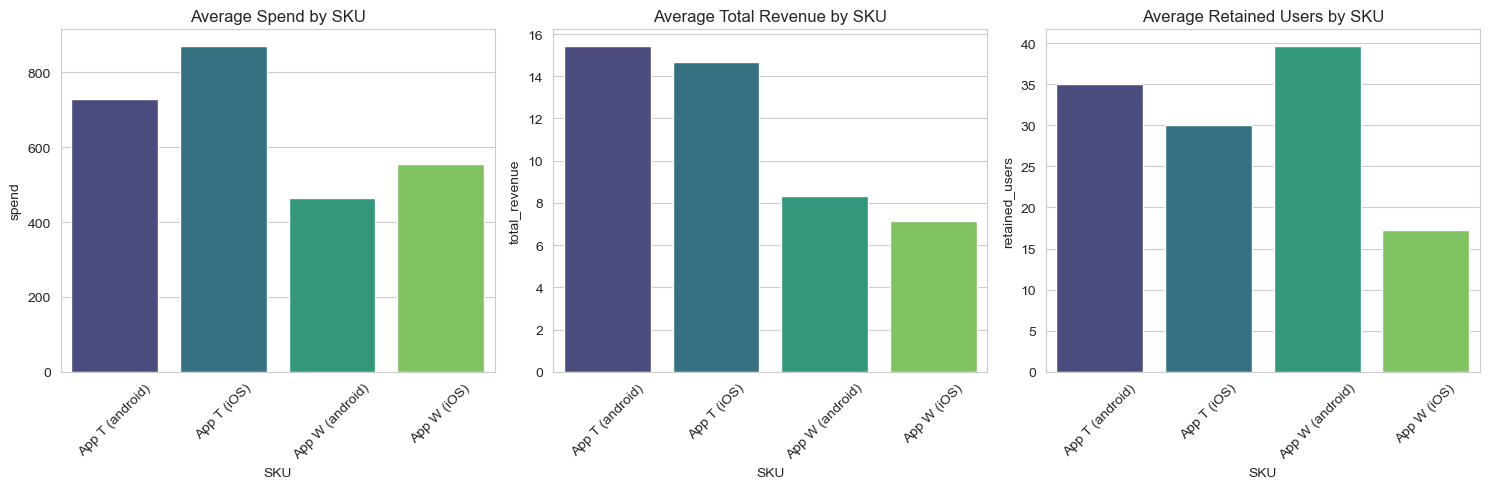

In [12]:

# Grouping data by 'sku' and calculating the mean for selected metrics
sku_grouped = data.groupby('sku').agg({
    'spend': 'mean',
    'total_revenue': 'mean',
    'retained_users': 'mean'
}).reset_index()

# Sorting the dataframe by total revenue for better visualization
sku_grouped = sku_grouped.sort_values(by='total_revenue', ascending=False)

# Plotting the metrics by sku
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, metric, title in zip(axes, metrics, plot_titles):
    sns.barplot(x='sku', y=metric, data=sku_grouped, ax=ax, palette='viridis')
    ax.set_title(title.replace("Network", "SKU"))
    ax.set_ylabel(metric)
    ax.set_xlabel('SKU')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
    

"App T (android)" comes at the top but its iOS counterpart is quite close - although the android app gets less spend budget. "App W (android)" retains much better than the rest although it doesn't monetize as good as the others.

In [13]:

# Creating the 'total_organic_revenue' column
data['total_organic_revenue'] = data['organic_revenue_ad'] + data['organic_revenue_iap'] + data['organic_revenue_sub']

# Creating the 'total_organic_revenue' column
data['total_organic_revenue'] = data['organic_revenue_ad'] + data['organic_revenue_iap'] + data['organic_revenue_sub']
    

In [14]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

# Preparing the data
model_data = data.copy()

# Encoding categorical variables

model_data = pd.get_dummies(data, columns=['network_name', 'sku', 'region'], drop_first=True)
dummy_columns = [col for col in model_data.columns if col not in data.columns]

# Selecting features for the regression model
features = ['spend', 'cohort_size', 'organic_cohort_size', 'retained_users', 
            'organic_retained_users'] + dummy_columns

X = model_data[features]
y = model_data['total_revenue']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training the linear regression model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Predicting on the test set
y_pred = regressor.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

coefficients_ = pd.DataFrame({
    'Feature': features,
    'Coefficient': regressor.coef_
}).sort_values(by='Coefficient', ascending=False)

print('Mean Squared Error: {:.2f}'.format(mse))
print('R2 Score: {:.2f}'.format(r2))
coefficients_


Mean Squared Error: 12794.72
R2 Score: 0.34


,Feature,Coefficient
10,region_T1,19.407665
12,region_T3,6.900600
13,region_T4,6.768428
11,region_T2,4.085476
4,organic_retained_users,0.780518
3,retained_users,0.125213
5,network_name_Channel F,0.014909
0,spend,0.005702
1,cohort_size,-0.002332
2,organic_cohort_size,-0.021453


**Performance Metrics:**
- **Mean Squared Error (MSE):** \(12794.72\)
  - This metric represents the average squared difference between the predicted values and the actual values. A lower MSE indicates a better fit of the model to the data. In this case, the MSE of \(12794.72\) indicates the magnitude of the error made by the model in its predictions.
  
- **\( R^2 \) Score:** \(0.3375\)
  - The \( R^2 \) score, also known as the coefficient of determination, measures the proportion of the variance in the dependent variable that is predictable from the independent variables. An \( R^2 \) score of \(0.3375\) suggests that the model explains about 33.75% of the variance in the target variable. This is a low \( R^2 \) value, which means the model captures very little of the underlying structure of the data and needs improvement.

**Feature Coefficients:**

The coefficients represent the change in the dependent variable (in this case, `total_revenue`) for a one-unit change in the predictor variable, while holding all other predictors constant.

1. **Regions (T1, T3, T4, T2):** 
   - `region_T1` has the highest positive coefficient of \(19.41\), suggesting that being in this region is associated with a significant increase in `total_revenue`. The other regions (`region_T3`, `region_T4`, `region_T2`) also have positive coefficients, but with decreasing magnitude. This implies a hierarchy in terms of contribution to `total_revenue`, with `region_T1` being the most influential.
  
2. **Retention Columns:**
   - `organic_retained_users` has a positive coefficient of \(0.78\), which means for every additional user retained organically, the `total_revenue` increases by approximately \(0.78\). 
   - `retained_users` has a coefficient of \(0.13\), indicating a smaller positive impact on `total_revenue` compared to organic retained users.
   
3. **Networks:**
   - The coefficient for `network_name_Channel F` is \(0.0149\), implying a slight increase in `total_revenue` associated with this network.
   - `network_name_Channel U` has a negative coefficient, suggesting a decrease in `total_revenue` for this channel compared to the reference network.
   
4. **Spend:** A coefficient of \(0.0057\) indicates that for every unit increase in spend, there's a small positive effect on `total_revenue`.

5. **Cohort Sizes:** 
   - The negative coefficient for `cohort_size` (-0.0023) suggests a very slight decrease in `total_revenue` for every unit increase in the cohort size.
   - The negative coefficient for `organic_cohort_size` is larger in magnitude (-0.0215), implying a more noticeable negative effect on `total_revenue`.

6. **SKUs:**
   - All SKUs (`sku_App T (iOS)`, `sku_App W (android)`, `sku_App W (iOS)`) have negative coefficients, suggesting they negatively impact `total_revenue`. Among them, `sku_App W (iOS)` has the largest negative coefficient, indicating it has the most significant negative impact on `total_revenue` compared to the reference SKU.

In [15]:
# Training the DecisionTreeRegressor
dt_regressor = DecisionTreeRegressor(random_state=42)
dt_regressor.fit(X_train, y_train)
y_dt_pred = dt_regressor.predict(X_test)

# Evaluating the DecisionTreeRegressor
mse_dt = mean_squared_error(y_test, y_dt_pred)
r2_dt = r2_score(y_test, y_dt_pred)

# Training the RandomForestRegressor
rf_regressor = RandomForestRegressor(random_state=42)
rf_regressor.fit(X_train, y_train)
y_rf_pred = rf_regressor.predict(X_test)

# Evaluating the RandomForestRegressor
mse_rf = mean_squared_error(y_test, y_rf_pred)
r2_rf = r2_score(y_test, y_rf_pred)

# Training the GradientBoostingRegressor
gb_regressor = GradientBoostingRegressor(random_state=42)
gb_regressor.fit(X_train, y_train)
y_gb_pred = gb_regressor.predict(X_test)

# Evaluating the GradientBoostingRegressor
mse_gb = mean_squared_error(y_test, y_gb_pred)
r2_gb = r2_score(y_test, y_gb_pred)

# Create DataFrames to store the results
results = pd.DataFrame({
    'Model': ['Linear Regression', 'DecisionTreeRegressor', 'RandomForestRegressor', 'GradientBoostingRegressor'],
    'Mean Squared Error': [mse, mse_dt, mse_rf, mse_gb],
    'R-squared': [r2, r2_dt, r2_rf, r2_gb]
})

# Display the results
print(results)

                       Model  Mean Squared Error  R-squared
0          Linear Regression        12794.717990   0.337548
1      DecisionTreeRegressor         6608.237033   0.657856
2      RandomForestRegressor         3646.624408   0.811194
3  GradientBoostingRegressor         2640.025031   0.863312


**Analysis Summary:**
- The model moderately fits the data, capturing around 33.75% of the variance in `total_revenue`.
- Regions play a significant role in predicting `total_revenue`, with `region_T1` having the most substantial positive impact.
- Retention of organic users is more influential than general user retention in terms of increasing `total_revenue`.
- Among the SKUs, `sku_App W (iOS)` has the highest negative impact on the revenue, suggesting potential areas for business improvement.
- While spend has a positive impact on `total_revenue`, the effect of cohort sizes is slightly negative, implying that other factors, such as user quality, might play a more crucial role than sheer numbers.

In [16]:
# Splitting the data into training and testing sets for the new target variable
y_organic = data['total_organic_revenue']
X_train_organic, X_test_organic, y_train_organic, y_test_organic = train_test_split(X, y_organic, test_size=0.2, random_state=42)

# Training the linear regression model for the new target variable
regressor_organic = LinearRegression()
regressor_organic.fit(X_train_organic, y_train_organic)

# Predicting on the test set
y_pred_organic = regressor_organic.predict(X_test_organic)

# Evaluating the model
mse_organic = mean_squared_error(y_test_organic, y_pred_organic)
r2_organic = r2_score(y_test_organic, y_pred_organic)


# Extracting the coefficients for predicting total_organic_revenue
coefficients_organic = pd.DataFrame({
    'Feature': features,
    'Coefficient': regressor_organic.coef_
}).sort_values(by='Coefficient', ascending=False)



mse_organic, r2_organic, coefficients_organic

(648.6225742611537,
 0.6572976949979126,
                    Feature  Coefficient
 10               region_T1    10.025356
 13               region_T4     4.583973
 12               region_T3     4.537655
 11               region_T2     1.978110
 4   organic_retained_users     0.598661
 6   network_name_Channel U     0.557265
 0                    spend     0.000455
 1              cohort_size    -0.000329
 2      organic_cohort_size    -0.006578
 3           retained_users    -0.030335
 5   network_name_Channel F    -0.987241
 7          sku_App T (iOS)    -1.037172
 8      sku_App W (android)    -1.377089
 9          sku_App W (iOS)    -2.296003)

**Performance Metrics:**
- **Mean Squared Error (MSE):** \(648.62\)
  - The MSE represents the average squared difference between the predicted and actual values. An MSE of \(648.62\) indicates the magnitude of the error made by the model in its predictions. A lower MSE is better as it indicates a tighter fit of the model to the data.
  
- **\( R^2 \) Score:** \(0.6573\)
  - The \( R^2 \) score measures the proportion of the variance in the dependent variable that is predictable from the independent variables. An \( R^2 \) score of \(0.6573\) suggests that the model explains about 65.73% of the variance in `total_organic_revenue`. This is a better score \( R^2 \) than the non-organic model, indicating that the model captures a significant portion of the underlying structure of the data.

**Feature Coefficients:**

1. **Regions (T1, T4, T3, T2):** 
   - `region_T1` has the highest positive coefficient of \(10.03\), indicating that being in this region is associated with a significant increase in `total_organic_revenue`. The other regions also have positive coefficients but with decreasing magnitude, suggesting that `region_T1` is the most influential among them.
  
2. **Retention and Cohort Sizes:**
   - `organic_retained_users` has a positive coefficient of \(0.60\), implying that for every additional user retained organically, there's a moderate increase in `total_organic_revenue`.
   - Both `cohort_size` and `organic_cohort_size` have negative coefficients, indicating that an increase in these variables might lead to a slight decrease in `total_organic_revenue`. This suggests that the quality of users (in terms of revenue generation) might be more crucial than sheer numbers.
   - `retained_users` has a negative coefficient of \(-0.03\), suggesting a small decrease in revenue for every unit increase in retained users. This might indicate that organic retention is more valuable than general retention.
   
3. **Networks:**
   - `network_name_Channel U` has a positive coefficient, suggesting that this network is associated with an increase in `total_organic_revenue` compared to the reference network.
   - `network_name_Channel F`, on the other hand, has a negative coefficient, indicating a decrease in revenue when this network is the source.

4. **Spend:** A coefficient of \(0.000455\) indicates a very slight positive effect of spend on `total_organic_revenue`.

5. **SKUs:**
   - All SKUs have negative coefficients, suggesting they reduce `total_organic_revenue` compared to the reference SKU. Among them, `sku_App W (iOS)` has the most significant negative impact, followed by `sku_App W (android)`, `sku_App T (iOS)`, and then `network_name_Channel F`.

**Analysis Summary:**
- The model has a fairly good fit, capturing around 65.73% of the variance in `total_organic_revenue`.
- Regional factors play a significant role, with `region_T1` being the most influential in predicting organic revenue.
- Organic retention has a positive influence on revenue, while general retention seems to have a slight negative impact. This might indicate the quality of organic users is superior in terms of revenue generation.
- The SKU `sku_App W (iOS)` has the most substantial negative impact on organic revenue, suggesting potential areas for business improvement or re-evaluation of the product or marketing strategies associated with this SKU.

Would you like to delve deeper into any specific aspect or continue with other requests?

In [17]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Adding 'days_after_install' to the features for the total_revenue prediction

# Define the extended feature set
features_total_revenue_extended = features + ['days_after_install']
X_total_revenue_extended = model_data[features_total_revenue_extended]

# Split the data into training and testing sets for the extended feature set
X_train_total_revenue_extended, X_test_total_revenue_extended, y_train_total_revenue_extended, y_test_total_revenue_extended = train_test_split(X_total_revenue_extended, y, test_size=0.2, random_state=42)

# Train the linear regression model for the new feature set
regressor_total_revenue_extended = LinearRegression()
regressor_total_revenue_extended.fit(X_train_total_revenue_extended, y_train_total_revenue_extended)

# Predict on the test set
y_pred_total_revenue_extended = regressor_total_revenue_extended.predict(X_test_total_revenue_extended)

# Evaluate the linear regression model
mse_total_revenue_extended = mean_squared_error(y_test_total_revenue_extended, y_pred_total_revenue_extended)
r2_total_revenue_extended = r2_score(y_test_total_revenue_extended, y_pred_total_revenue_extended)

# Extract the coefficients for the extended linear regression model
coefficients_total_revenue_extended = pd.DataFrame({
    'Feature': features_total_revenue_extended,
    'Coefficient': regressor_total_revenue_extended.coef_
}).sort_values(by='Coefficient', ascending=False)

# Train the DecisionTreeRegressor for the extended feature set
dt_regressor_total_revenue_extended = DecisionTreeRegressor(random_state=42)
dt_regressor_total_revenue_extended.fit(X_train_total_revenue_extended, y_train_total_revenue_extended)
y_dt_pred_total_revenue_extended = dt_regressor_total_revenue_extended.predict(X_test_total_revenue_extended)

# Evaluate the DecisionTreeRegressor
mse_dt_total_revenue_extended = mean_squared_error(y_test_total_revenue_extended, y_dt_pred_total_revenue_extended)
r2_dt_total_revenue_extended = r2_score(y_test_total_revenue_extended, y_dt_pred_total_revenue_extended)

# Train the RandomForestRegressor for the extended feature set
rf_regressor_total_revenue_extended = RandomForestRegressor(random_state=42)
rf_regressor_total_revenue_extended.fit(X_train_total_revenue_extended, y_train_total_revenue_extended)
y_rf_pred_total_revenue_extended = rf_regressor_total_revenue_extended.predict(X_test_total_revenue_extended)

# Evaluate the RandomForestRegressor
mse_rf_total_revenue_extended = mean_squared_error(y_test_total_revenue_extended, y_rf_pred_total_revenue_extended)
r2_rf_total_revenue_extended = r2_score(y_test_total_revenue_extended, y_rf_pred_total_revenue_extended)

# Train the GradientBoostingRegressor for the extended feature set
gb_regressor_total_revenue_extended = GradientBoostingRegressor(random_state=42)
gb_regressor_total_revenue_extended.fit(X_train_total_revenue_extended, y_train_total_revenue_extended)
y_gb_pred_total_revenue_extended = gb_regressor_total_revenue_extended.predict(X_test_total_revenue_extended)

# Evaluate the GradientBoostingRegressor
mse_gb_total_revenue_extended = mean_squared_error(y_test_total_revenue_extended, y_gb_pred_total_revenue_extended)
r2_gb_total_revenue_extended = r2_score(y_test_total_revenue_extended, y_gb_pred_total_revenue_extended)

# Extract the feature importances for RandomForestRegressor and GradientBoostingRegressor
feature_importance_rf = rf_regressor_total_revenue_extended.feature_importances_
feature_importance_gb = gb_regressor_total_revenue_extended.feature_importances_

# Create DataFrames to store the results
results_extended = pd.DataFrame({
    'Model': ['Linear Regression', 'DecisionTreeRegressor', 'RandomForestRegressor', 'GradientBoostingRegressor'],
    'Mean Squared Error': [mse_total_revenue_extended, mse_dt_total_revenue_extended, mse_rf_total_revenue_extended, mse_gb_total_revenue_extended],
    'R-squared': [r2_total_revenue_extended, r2_dt_total_revenue_extended, r2_rf_total_revenue_extended, r2_gb_total_revenue_extended]
})

# Display the results
print("Results for the extended feature set:")
print(results_extended)

# Display the feature importances for RandomForestRegressor and GradientBoostingRegressor
print("Feature Importances (RandomForestRegressor):")
print(dict(zip(features_total_revenue_extended, feature_importance_rf)))

print("Feature Importances (GradientBoostingRegressor):")
print(dict(zip(features_total_revenue_extended, feature_importance_gb)))

Results for the extended feature set:
                       Model  Mean Squared Error  R-squared
0          Linear Regression        12788.933178   0.337848
1      DecisionTreeRegressor         3124.423207   0.838232
2      RandomForestRegressor         1221.501076   0.936756
3  GradientBoostingRegressor         1421.177399   0.926418
Feature Importances (RandomForestRegressor):
{'spend': 0.10754655822385514, 'cohort_size': 0.022449211097139928, 'organic_cohort_size': 0.012785786590674995, 'retained_users': 0.5968442289082433, 'organic_retained_users': 0.031207952276078824, 'network_name_Channel F': 0.0023820794070324412, 'network_name_Channel U': 0.0025794208538622637, 'sku_App T (iOS)': 0.007222910125780511, 'sku_App W (android)': 0.004637540323135653, 'sku_App W (iOS)': 0.0016898026299120095, 'region_T1': 0.11790051198957292, 'region_T2': 0.008901890962446861, 'region_T3': 8.122272002971039e-05, 'region_T4': 1.093049354536451e-06, 'days_after_install': 0.08376979084288083}
Feature 

## Presenting the Results to Subject Matter Experts

When presenting the results to a subject-matter expert, eventhough the score was pretty high for Random Forest, and GradientBoosting models, the expert was not satisfied with the results. The model was not able to predict revenue coherently with different values of  `days_after_install`. For example:

- Revenue should consistently increase with `days_after_install` but the model was not able to capture this trend.
- Growth percentages between cohorts was either to low or too high, not really caputring the real growth percentages for the players of a given game.
- Some numbers where negative, which is not possible in the real world (specially with RandomForest).


## Takeaways after the Presentation

After talking to subject-matter experts, a few important determinations were made: The data will be "easier to analyze" if it's structured in a "cohorted" way. This means:
- look at aggregated KPIs by date, using the `days_after_install` diimension to create different KPI buckets.
- each bucket helps to understand how user retention affects performance over time (revenue, mainly)
- other dimensions like network, region, sku can be part of the high level aggregation (which is a common practice)

Based on the feedback provided above, a new dataframe was created:

In [18]:
# Calculating d0_revenue, d7_revenue, d0_spend, d0_cohort_size, and d7_retained_users
grouped_data_efficient = data.groupby(['date', 'network_name', 'region', 'sku']).agg({
    'total_revenue': [
        ('d0_revenue', lambda x: x[data['days_after_install'] == 0].sum()),
        ('d7_revenue', lambda x: x[data['days_after_install'] <= 7].sum()),
        ('d14_revenue', lambda x: x[data['days_after_install'] <= 14].sum()),
    ],
    'spend': lambda x: x[data['days_after_install'] == 0].sum(),  # d0_spend
    'cohort_size': lambda x: x[data['days_after_install'] == 0].sum(),  # d0_cohort_size
    'retained_users': lambda x: x[data['days_after_install'] == 7].sum()  # d7_retained_users
}).reset_index()

# Flattening the multi-index columns
grouped_data_efficient.columns = ['_'.join(col).strip() for col in grouped_data_efficient.columns.values]

# Applying one-hot encoding to 'sku', 'network_name', and 'region'
encoded_data_efficient = pd.get_dummies(grouped_data_efficient, columns=['sku_', 'network_name_', 'region_'], drop_first=True)

encoded_data_efficient.head()


,date_,total_revenue_d0_revenue,total_revenue_d7_revenue,total_revenue_d14_revenue,spend_<lambda>,cohort_size_<lambda>,retained_users_<lambda>,sku__App T (iOS),sku__App W (android),sku__App W (iOS),network_name__Channel F,network_name__Channel U,region__T1,region__T2,region__T3,region__T4
0,2021-01-01,0.00,0.15,0.15,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0
1,2021-01-01,19.02,19.02,19.02,123.2,389.0,0.0,1,0,0,0,0,0,0,0,0
2,2021-01-01,0.00,0.00,0.00,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0
3,2021-01-01,0.00,0.00,0.00,0.0,0.0,0.0,0,1,0,0,0,1,0,0,0
4,2021-01-01,0.00,0.00,0.00,0.0,0.0,0.0,0,0,1,0,0,1,0,0,0


new data structure:
- **total_revenue_d0_revenue**: revenue generated the day users installed the app on a given date.
- **d7_paid_revenue**: revenue generated in the first `7 days` after users installed the app on a given date.
- **d14_paid_revenue**: revenue generated in the first `14 days` after users installed the app on a given date.
- **cohort_size**: the amount of users that installed the game on a given date.
- **spend**: the marketing campaign budget invested on a given date.
- **retained_users**: users still active `7 days` after their install date.

In [19]:
encoded_data_efficient.describe()

,total_revenue_d0_revenue,total_revenue_d7_revenue,total_revenue_d14_revenue,spend_<lambda>,cohort_size_<lambda>,retained_users_<lambda>,sku__App T (iOS),sku__App W (android),sku__App W (iOS),network_name__Channel F,network_name__Channel U,region__T1,region__T2,region__T3,region__T4
count,33361.000000,33361.000000,33361.000000,33361.000000,33361.000000,33361.000000,33361.000000,33361.000000,33361.000000,33361.000000,33361.000000,33361.000000,33361.000000,33361.000000,33361.000000
mean,2.069887,4.455631,5.268311,9.152628,7.090285,0.653458,0.250772,0.248734,0.251431,0.333563,0.334193,0.202662,0.200324,0.197296,0.199844
std,63.058133,70.129591,70.933706,241.012947,202.598806,13.526024,0.433464,0.432286,0.433842,0.471493,0.471715,0.401989,0.400249,0.397964,0.399889
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,6907.877100,6907.877100,6907.877100,26812.976303,23287.000000,874.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
# Selecting features and target for the regression model
features_efficient = encoded_data_efficient.columns.difference(['date_', 'total_revenue_d14_revenue'])
X_efficient = encoded_data_efficient[features_efficient]
y_efficient = encoded_data_efficient['total_revenue_d14_revenue']

# Splitting the data into training and testing sets
X_train_efficient, X_test_efficient, y_train_efficient, y_test_efficient = train_test_split(X_efficient, y_efficient, test_size=0.2, random_state=42)

# Training the linear regression model
regressor_efficient = LinearRegression()
regressor_efficient.fit(X_train_efficient, y_train_efficient)

# Predicting on the test set
y_pred_efficient = regressor_efficient.predict(X_test_efficient)

# Evaluating the model
mse_efficient = mean_squared_error(y_test_efficient, y_pred_efficient)
r2_efficient = r2_score(y_test_efficient, y_pred_efficient)

# Extracting the coefficients for the extended model
coefficients_total_revenue_d14_revenue = pd.DataFrame({
    'Feature': features_efficient,
    'Coefficient': regressor_efficient.coef_
}).sort_values(by='Coefficient', ascending=False)

mse_efficient, r2_efficient, coefficients_total_revenue_d14_revenue


(118.74777524528504,
 0.9565506146145041,
                      Feature  Coefficient
 3                 region__T1     2.822888
 13  total_revenue_d7_revenue     1.008474
 4                 region__T2     0.261134
 1    network_name__Channel F     0.143476
 2    network_name__Channel U     0.112767
 7    retained_users_<lambda>     0.009677
 0       cohort_size_<lambda>    -0.000036
 11            spend_<lambda>    -0.000747
 12  total_revenue_d0_revenue    -0.005317
 5                 region__T3    -0.130446
 6                 region__T4    -0.137429
 8           sku__App T (iOS)    -0.143181
 9       sku__App W (android)    -0.444952
 10          sku__App W (iOS)    -0.661033)

**Performance Metrics:**
- **Mean Squared Error (MSE):** \(118.75\)
  - The MSE measures the average squared difference between the predicted and actual values. An MSE of \(118.75\) indicates the magnitude of the error made by the model in its predictions. A lower MSE signifies a better fit of the model to the data. In this case, the relatively low MSE suggests that the model predictions are quite accurate.
  
- **\( R^2 \) Score:** \(0.9566\)
  - The \( R^2 \) score measures the proportion of the variance in the dependent variable that is predictable from the independent variables. An \( R^2 \) score of \(0.9566\) suggests that the model explains about 95.66% of the variance in `total_revenue_d14_revenue`. This is an excellent \( R^2 \) value, indicating that the model provides a very good fit to the data.

**Feature Coefficients:**

1. **Regions:**
   - `region__T1` has the highest positive coefficient of \(2.82\), suggesting that being in this region is significantly associated with an increase in `total_revenue_d14_revenue`. 
   - `region__T2` also has a positive effect, though it's smaller in magnitude.
   - `region__T3` and `region__T4` both have negative coefficients, indicating that these regions might see lower revenues at Day 14 compared to the reference region.
  
2. **D7 Revenue:** 
   - `total_revenue_d7_revenue` has a coefficient of \(1.0085\). This indicates a strong positive relationship between revenues at Day 7 and Day 14. Essentially, for every unit increase in Day 7 revenue, there's almost an equivalent increase in Day 14 revenue.
   
3. **Networks:**
   - Both `network_name__Channel F` and `network_name__Channel U` have positive coefficients, suggesting that these networks contribute positively to the Day 14 revenue compared to the reference network.
   
4. **Retention, Cohort Size, and Spend:** 
   - `retained_users` has a positive coefficient, showing that higher retention is associated with higher Day 14 revenue.
   - Both `cohort_size` and `spend` have very small negative coefficients, indicating a slight decrease in Day 14 revenue with increasing values. This suggests that while acquiring more users and spending more might be crucial for initial revenues, they don't significantly contribute to Day 14 revenues.
   
5. **SKUs:**
   - All SKUs have negative coefficients. Among them, `sku__App W (iOS)` has the most significant negative impact on Day 14 revenue, followed by `sku__App W (android)` and `sku__App T (iOS)`. This indicates that these SKUs are associated with decreased revenues compared to the reference SKU.

**Analysis Summary:**
- The model provides an excellent fit to the data, capturing around 95.66% of the variance in `total_revenue_d14_revenue`.
- The revenue at Day 7 is a strong predictor of revenue at Day 14, indicating the importance of early user engagement and monetization.
- Regional factors, especially being in `region__T1`, play a significant role in predicting Day 14 revenue.
- While retention positively impacts Day 14 revenue, sheer user numbers (cohort size) and marketing spend are not as influential in the longer term (by Day 14).
- The SKUs `sku__App W (iOS)`, `sku__App W (android)`, and `sku__App T (iOS)` negatively impact Day 14 revenues, suggesting potential areas for business strategy reconsideration or product improvements for these SKUs.

In [21]:
cohorted_df = data.groupby(['date', 'network_name', 'region', 'sku']).agg({
    'total_revenue': [
        ('d0_revenue', lambda x: x[data['days_after_install'] == 0].sum()),
        ('d7_revenue', lambda x: x[data['days_after_install'] <= 7].sum()),
        ('d14_revenue', lambda x: x[data['days_after_install'] <= 14].sum()),
    ],
    'spend': lambda x: x[data['days_after_install'] == 0].sum(),  # d0_spend
    'cohort_size': lambda x: x[data['days_after_install'] == 0].sum(),  # d0_cohort_size
    'retained_users': lambda x: x[data['days_after_install'] == 7].sum()  # d7_retained_users
}).reset_index()

# Flattening the multi-index columns
cohorted_df.columns = ['_'.join(col).strip() for col in cohorted_df.columns.values]

cohorted_df

,date_,network_name_,region_,sku_,total_revenue_d0_revenue,total_revenue_d7_revenue,total_revenue_d14_revenue,spend_<lambda>,cohort_size_<lambda>,retained_users_<lambda>
0,2021-01-01,Channel A,Other,App T (android),0.0000,0.1500,0.1500,0.0000,0.0,0.0
1,2021-01-01,Channel A,Other,App T (iOS),19.0200,19.0200,19.0200,123.2000,389.0,0.0
2,2021-01-01,Channel A,Other,App W (iOS),0.0000,0.0000,0.0000,0.0000,0.0,0.0
3,2021-01-01,Channel A,T1,App W (android),0.0000,0.0000,0.0000,0.0000,0.0,0.0
4,2021-01-01,Channel A,T1,App W (iOS),0.0000,0.0000,0.0000,0.0000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
33356,2023-08-03,Channel A,Other,App W (android),0.0000,33.2617,33.2617,0.0000,0.0,0.0
33357,2023-08-03,Channel U,T3,App T (iOS),0.0000,0.0000,0.0000,0.0000,0.0,0.0
33358,2023-08-05,Channel U,T2,App T (iOS),0.0000,0.0000,0.0000,0.0000,0.0,0.0
33359,2023-08-06,Channel A,Other,App T (android),3.6887,3.6887,3.6887,8.0835,41.0,0.0


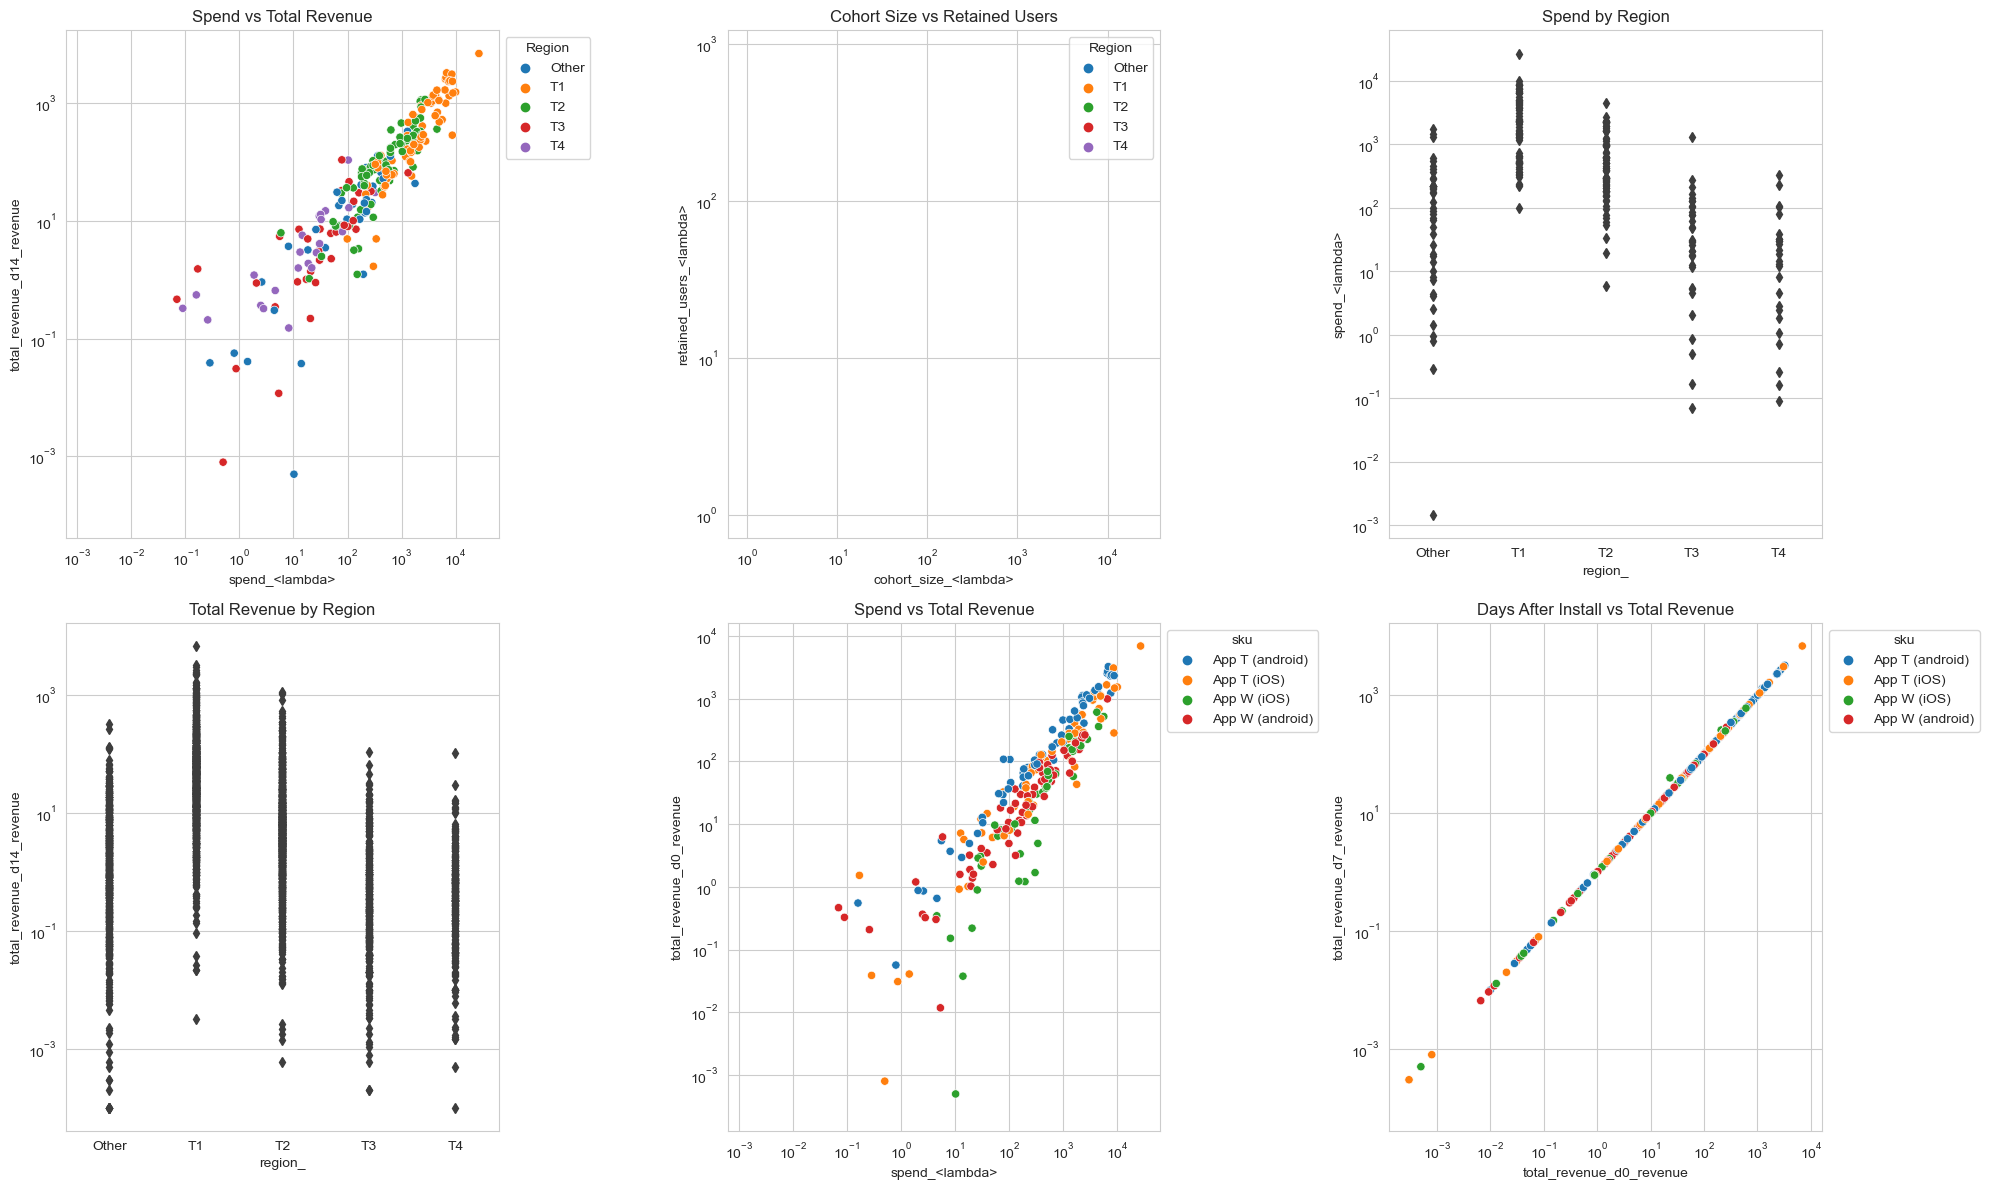

In [22]:
# Multivariate plots
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Scatter plot for spend vs total revenue
sns.scatterplot(data=cohorted_df, x='spend_<lambda>', y='total_revenue_d14_revenue', hue='region_', ax=axes[0, 0])
axes[0, 0].set_title('Spend vs Total Revenue')
axes[0, 0].set_xscale('log')
axes[0, 0].set_yscale('log')
axes[0, 0].legend(title='Region', bbox_to_anchor=(1, 1))

# 2. Scatter plot for cohort size vs retained users
sns.scatterplot(data=cohorted_df, x='cohort_size_<lambda>', y='retained_users_<lambda>', hue='region_', ax=axes[0, 1])
axes[0, 1].set_title('Cohort Size vs Retained Users')
axes[0, 1].set_xscale('log')
axes[0, 1].set_yscale('log')
axes[0, 1].legend(title='Region', bbox_to_anchor=(1, 1))

# 3. Box plot for spend by region
sns.boxplot(data=cohorted_df, x='region_', y='spend_<lambda>', ax=axes[0, 2])
axes[0, 2].set_title('Spend by Region')
axes[0, 2].set_yscale('log')

# 4. Box plot for total revenue by region
sns.boxplot(data=cohorted_df, x='region_', y='total_revenue_d14_revenue', ax=axes[1, 0])
axes[1, 0].set_title('Total Revenue by Region')
axes[1, 0].set_yscale('log')

# 5. Scatter plot for spend vs total revenue
sns.scatterplot(data=cohorted_df, x='spend_<lambda>', y='total_revenue_d0_revenue', hue='sku_', ax=axes[1, 1])
axes[1, 1].set_title('Spend vs Total Revenue')
axes[1, 1].set_xscale('log')
axes[1, 1].set_yscale('log')
axes[1, 1].legend(title='sku', bbox_to_anchor=(1, 1))

# 6. Scatter plot for spend vs total revenue
sns.scatterplot(data=cohorted_df, x='total_revenue_d0_revenue', y='total_revenue_d7_revenue', hue='sku_', ax=axes[1, 2])
axes[1, 2].set_title('Days After Install vs Total Revenue')
axes[1, 2].set_xscale('log')
axes[1, 2].set_yscale('log')
axes[1, 2].legend(title='sku', bbox_to_anchor=(1, 1))


plt.tight_layout()
plt.show()
    

## EUREKA MOMENT! 

when looking at the D0-D7 revenue correlation, I thought that maybe current revenue growth could predict revenue 30 days into the future

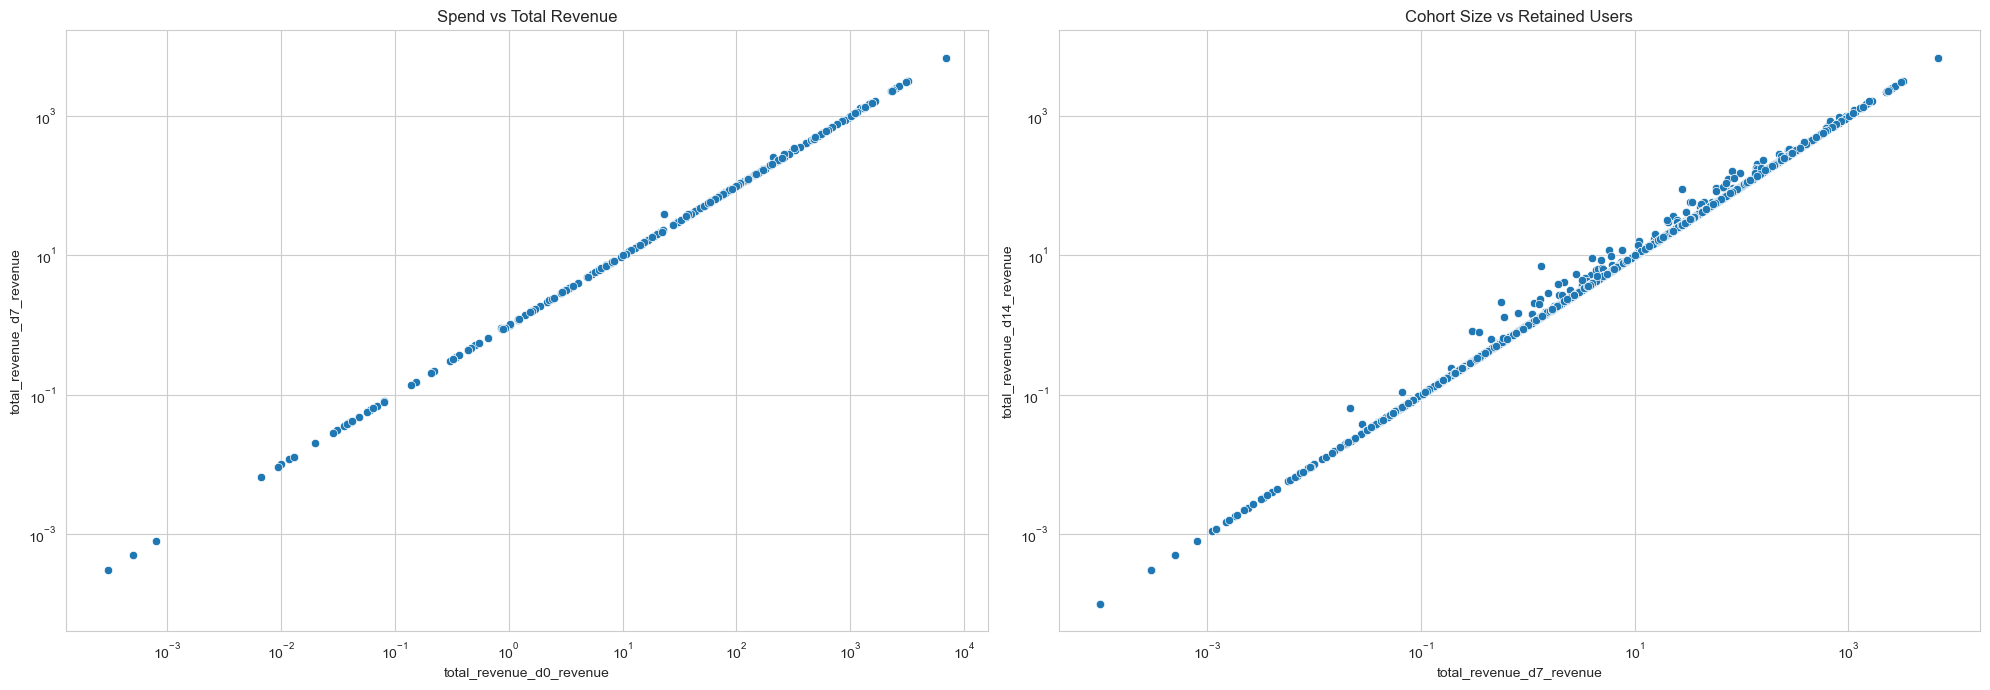

In [23]:
# Multivariate plots
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# 1. Scatter plot for spend vs total revenue
sns.scatterplot(data=cohorted_df, x='total_revenue_d0_revenue', y='total_revenue_d7_revenue', ax=axes[0])
axes[0].set_title('Spend vs Total Revenue')
axes[0].set_xscale('log')
axes[0].set_yscale('log')

# 2. Scatter plot for cohort size vs retained users
sns.scatterplot(data=cohorted_df, x='total_revenue_d7_revenue', y='total_revenue_d14_revenue', ax=axes[1])
axes[1].set_title('Cohort Size vs Retained Users')
axes[1].set_xscale('log')
axes[1].set_yscale('log')


plt.tight_layout()
plt.show()
    